# Задание к занятию «Элементарные алгоритмы обработки временных рядов»

    
Взять с сайта ряд (в двух вариантах - стационарный и нет) и приблизить оба эти варианта моделями из класса MA. Оценить качество и прислать соображения в почему была выбрана та или иная модель. (задание оформить в jupyter-notebook)


In [161]:
import os
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from scipy.stats import boxcox
from sklearn.model_selection import TimeSeriesSplit
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error

%matplotlib inline

In [162]:
def test_stationarity(timeseries):
    '''Тестирование стационарности ряда по критерию Дики - Фуллера'''
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [163]:
def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    '''Отображение ряда'''
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (4, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)

        plt.tight_layout()
    return

In [164]:
def bc_transform(ts, lmbda = None):
    '''Осуществляет преобразование Бокса-Кокса с заданным lmbda'''
    '''Если lmbda не задана, определяет оптимальное значение, 
        максимизирующее функцию правдоподобия
    '''
    if lmbda is not None:
        res_ts = boxcox(ts, lmbda)
        lmbda_opt = lmbda
    else:
        res_ts, lmbda_opt = boxcox(ts)
    print('Applying Box-Cox tranform with lambda = {}'.format(lmbda_opt))
    return res_ts

## Квартальное потребление в UK за 1959 - 1991 годы

In [165]:
data  = pd.read_csv(os.path.join('quarterly-uk-private-fin.csv'), 
                         delimiter = ';')['Quarterly UK private final consumption expenditure. Sep 1959 to March 1991']*1.0


Для анализа будем рассматривать исходный ряд и его "стационарную" версию

Посмотрим на ряд. Легко заметить восходящий тренд и сезонность

Results of Dickey-Fuller Test:
Test Statistic                   1.282893
p-value                          0.996511
#Lags Used                      13.000000
Number of Observations Used    113.000000
Critical Value (1%)             -3.489590
Critical Value (5%)             -2.887477
Critical Value (10%)            -2.580604
dtype: float64


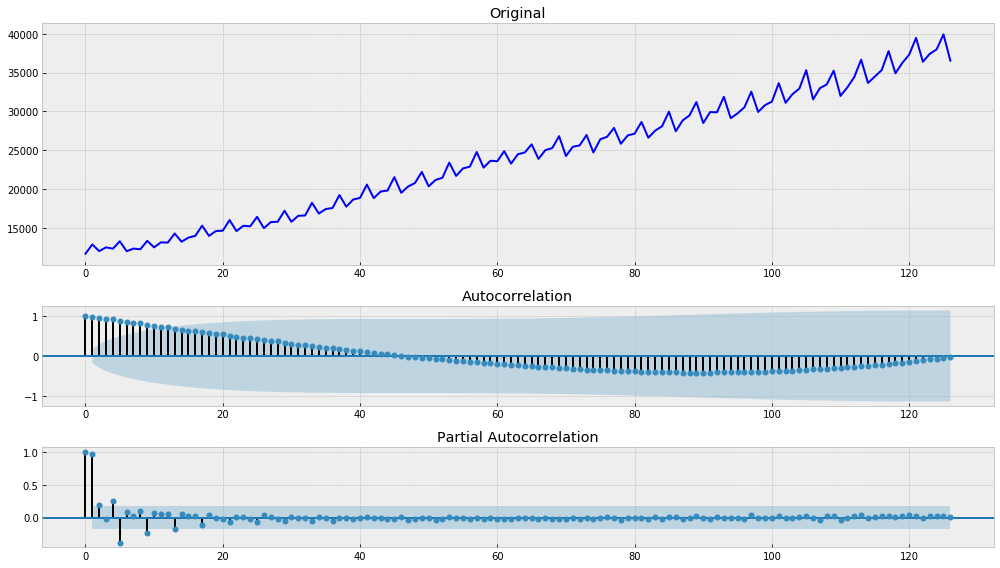

In [166]:
tsplot(data)

Проведем преобразование Бокса-Кокса. Для простоты возьмем $\lambda=0$

In [167]:
data_cons_bc = data

Results of Dickey-Fuller Test:
Test Statistic                   1.282893
p-value                          0.996511
#Lags Used                      13.000000
Number of Observations Used    113.000000
Critical Value (1%)             -3.489590
Critical Value (5%)             -2.887477
Critical Value (10%)            -2.580604
dtype: float64


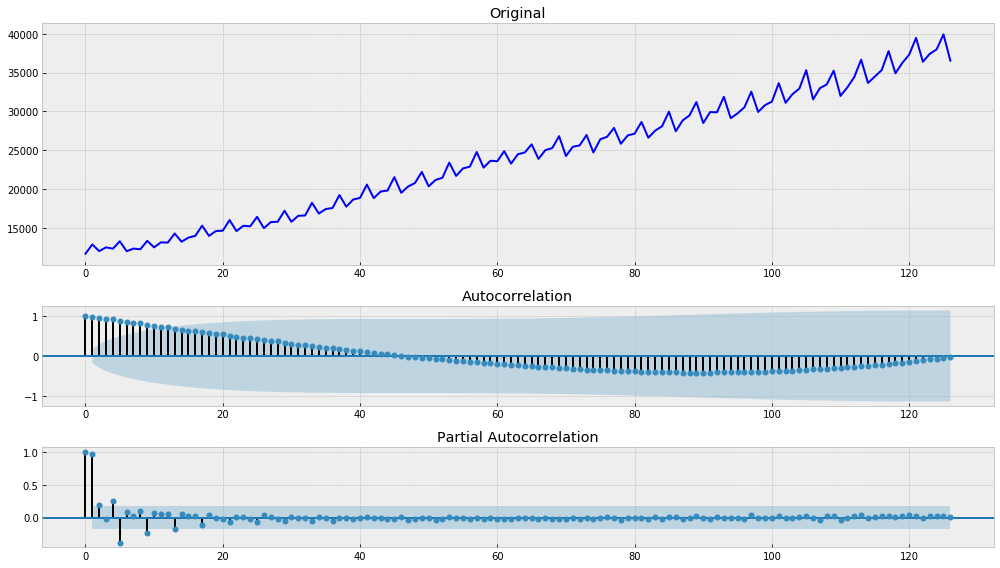

In [168]:
tsplot(data_cons_bc)

In [169]:
data_cons_diff = pd.Series(data_cons_bc).diff(1)[1:].reset_index(drop=True)

Results of Dickey-Fuller Test:
Test Statistic                  -3.824979
p-value                          0.002662
#Lags Used                      12.000000
Number of Observations Used    113.000000
Critical Value (1%)             -3.489590
Critical Value (5%)             -2.887477
Critical Value (10%)            -2.580604
dtype: float64


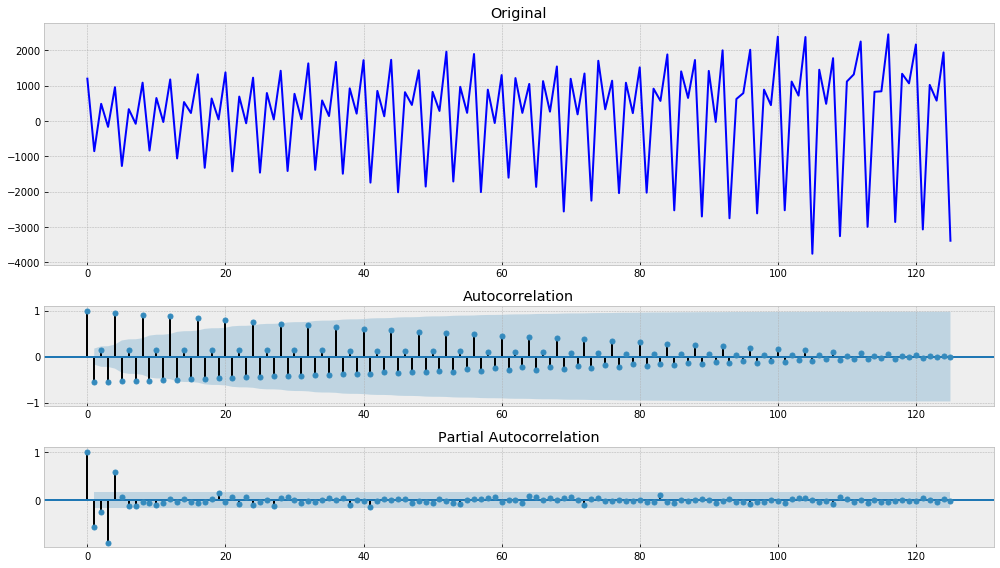

In [170]:
tsplot(data_cons_diff)

In [171]:
data_cons_clean = pd.Series(austrian_cons_diff).diff(4)[4:].reset_index(drop=True)

Results of Dickey-Fuller Test:
Test Statistic                  -5.593435
p-value                          0.000001
#Lags Used                      11.000000
Number of Observations Used    110.000000
Critical Value (1%)             -3.491245
Critical Value (5%)             -2.888195
Critical Value (10%)            -2.580988
dtype: float64


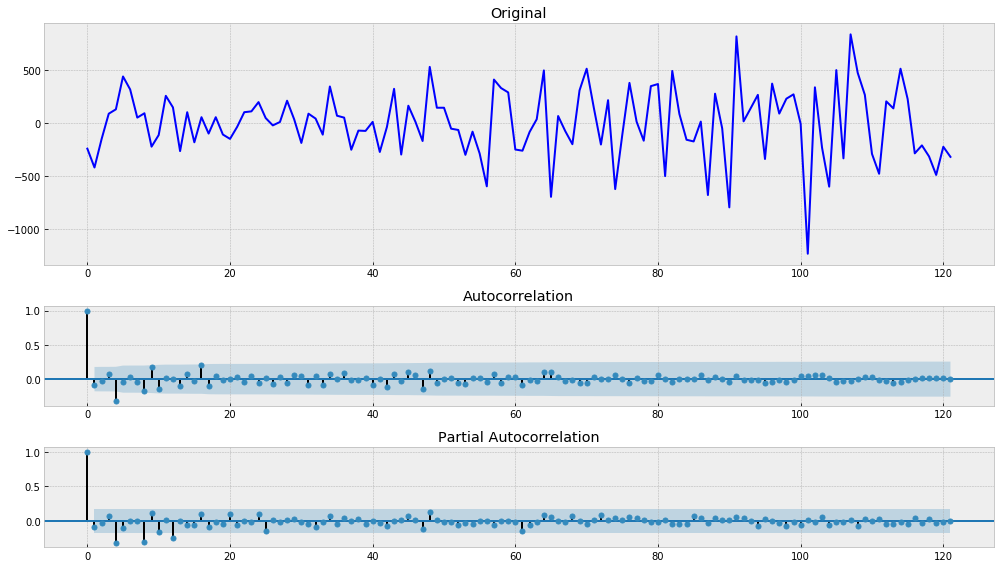

In [172]:
tsplot(austrian_cons_clean)

Тест Дики-Фуллера снова указывает на то, что ряд стационарен.  Поскольку требований к стационарности у используемых далее моделей нет, закончим преобразования


# Построение моделей

## Модель для исходного нестационарного ряда

Поскольку в исходном ряде наблюдаем и тренд, и сезонность, попробуем применить модель Хольта-Винтерса

In [173]:
def initial_trend(series, slen):
    sum = 0.0
    for i in range(slen):
        sum += float(series[i+slen] - series[i]) / slen
    return sum / slen

In [174]:
def initial_seasonal_components(series, slen):
    seasonals = {}
    season_averages = []
    n_seasons = int(len(series)/slen)
    # compute season averages
    for j in range(n_seasons):
        season_averages.append(sum(series[slen*j:slen*j+slen])/float(slen))
    # compute initial values
    for i in range(slen):
        sum_of_vals_over_avg = 0.0
        for j in range(n_seasons):
            sum_of_vals_over_avg += series[slen*j+i]-season_averages[j]
        seasonals[i] = sum_of_vals_over_avg/n_seasons
    return seasonals

In [175]:
def triple_exponential_smoothing(series, slen, alpha, beta, gamma, n_preds):
    result = []
    seasonals = initial_seasonal_components(series, slen)
    for i in range(len(series)+n_preds):
        if i == 0: # initial values
            smooth = series[0]
            trend = initial_trend(series, slen)
            result.append(series[0])
            continue
        if i >= len(series): # we are forecasting
            m = i - len(series) + 1
            result.append((smooth + m*trend) + seasonals[i%slen])
        else:
            val = series[i]
            last_smooth, smooth = smooth, alpha*(val-seasonals[i%slen]) + (1-alpha)*(smooth+trend)
            trend = beta * (smooth-last_smooth) + (1-beta)*trend
            seasonals[i%slen] = gamma*(val-smooth) + (1-gamma)*seasonals[i%slen]
            result.append(smooth+trend+seasonals[i%slen])
    return result

In [176]:
def plot_tema(alpha, beta, gamma, series, series_to_plot, n_preds=24):
    n_preds = min(n_preds,len(series_to_plot)-len(series)) 
    tema = triple_exponential_smoothing(series, 4, alpha, beta, gamma, n_preds)
    with plt.style.context('bmh'):
        plt.figure(figsize=(20, 8))
        plt.plot(series_to_plot, color='blue',linewidth='4', label='original')

        plt.plot(tema, color='orange', label='TEMA')
        plt.fill_between(range(len(series)), 0, series, color = 'orange', alpha = 0.3,  label = 'train area')
        plt.fill_between(range(len(series)-1, len(series_to_plot)), 0, series_to_plot[len(series)-1:],
                         color = 'green', alpha = 0.3,  label = 'predict area')
        plt.title("alpha={:.2f}, beta={:.2f}, gamma={:.2f}, n_preds = {}".format(alpha, beta, gamma, n_preds))
        
        plt.legend()

In [177]:
def mse_cross_val_tema(X):
    alpha, beta, gamma = X
    split = TimeSeriesSplit(n_splits=3) 
    errors = []
    
    for train_split, test_split in split.split(train):

        result = triple_exponential_smoothing(train[train_split], 12, alpha, beta, gamma, len(test_split))
        predictions = result[-len(test_split):]
        real_data = train[test_split]

        
        error = mean_squared_error(predictions, real_data)
        errors.append(error)
        
    return np.mean(np.array(errors))

Исходный ряд имеет 127 измерений. Возьмем интервал прогнозирования на 4 измерения вперед (1 год)

In [178]:
periods_to_predict = 4
train, val = data[:-periods_to_predict], data[-periods_to_predict:]

Найдем оптимальные значения параметров модели Хольта-Винтерса на кросс-валидации

In [179]:
opt = minimize(mse_cross_val_tema, x0=[0,0,0], method="L-BFGS-B", bounds = ((0, 1), (0, 1), (0, 1)))
alpha_opt, beta_opt, gamma_opt = opt.x
print('RMSE on cross val is {:.3f}'.format(opt.fun))

RMSE on cross val is 260460.662


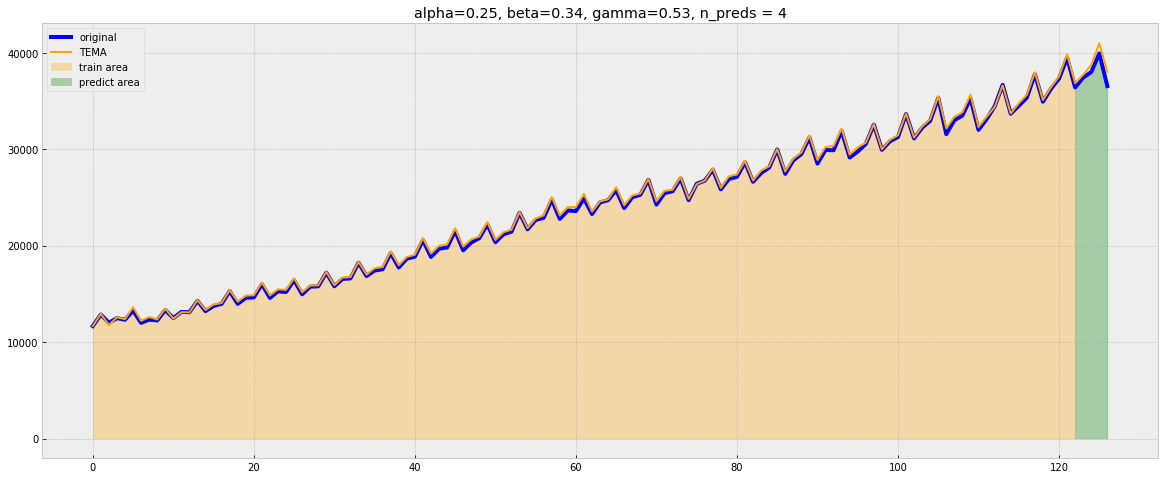

In [180]:
plot_tema(alpha_opt, beta_opt, gamma_opt,series = train, series_to_plot = data)

Посмотрим, что получается при других интервалах предсказания

RMSE on cross val is 1122983.490


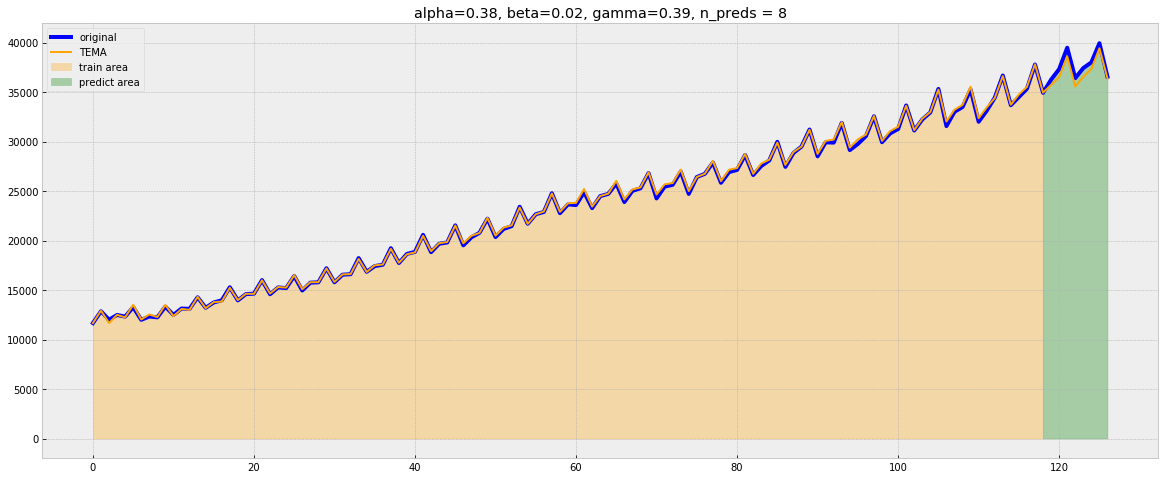

In [181]:
periods_to_predict = 8
train, val = data[:-periods_to_predict], data[-periods_to_predict:]
opt = minimize(mse_cross_val_tema, x0=[0,0,0], method="L-BFGS-B", bounds = ((0, 1), (0, 1), (0, 1)))
print('RMSE on cross val is {:.3f}'.format(opt.fun))
alpha_opt, beta_opt, gamma_opt = opt.x
plot_tema(alpha_opt, beta_opt, gamma_opt,series = train, series_to_plot = data)

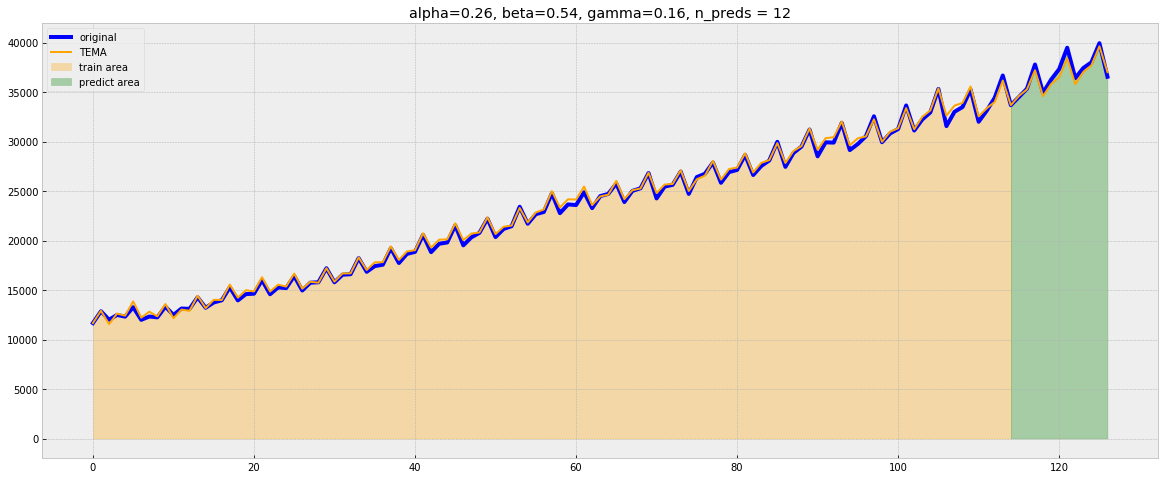

In [182]:
periods_to_predict = 12
train, val = data[:-periods_to_predict], data[-periods_to_predict:]
opt = minimize(mse_cross_val_tema, x0=[0,0,0], method="L-BFGS-B", bounds = ((0, 1), (0, 1), (0, 1)))
alpha_opt, beta_opt, gamma_opt = opt.x
plot_tema(alpha_opt, beta_opt, gamma_opt,series = train, series_to_plot = data)

RMSE on cross val is 950640.542


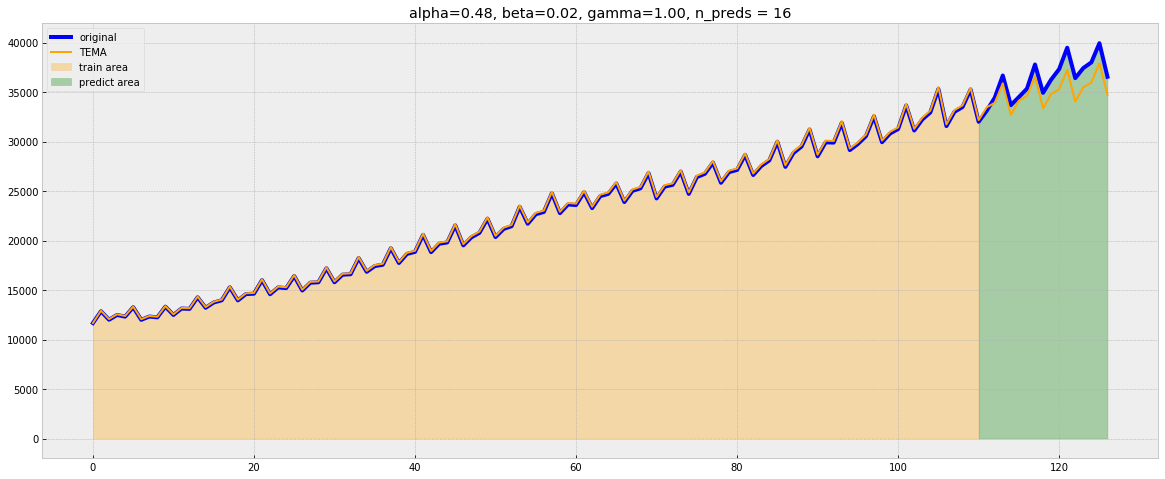

In [183]:
periods_to_predict = 16
train, val = data[:-periods_to_predict], data[-periods_to_predict:]
opt = minimize(mse_cross_val_tema, x0=[0,0,0], method="L-BFGS-B", bounds = ((0, 1), (0, 1), (0, 1)))
print('RMSE on cross val is {:.3f}'.format(opt.fun))
alpha_opt, beta_opt, gamma_opt = opt.x
plot_tema(alpha_opt, beta_opt, gamma_opt,series = train, series_to_plot = data)

## Модель прогноза для "стационарного ряда"

Пробуем использовать для прогноза EMA

In [184]:
def exponential_moving_average(series, alpha, n_pred=None):
    result = [series[0]]
    for n in range(1, len(series)):
        result.append(alpha * series[n-1] + (1 - alpha) * result[n-1])
    if not n_pred:
        return pd.Series(result)
    
    predictions = [alpha * series[len(series) - 1] + (1 - alpha) * result[-1]]

    for _ in range(n_pred):
        res = alpha * predictions[-1] + (1 - alpha) * result[-1]
        result.append(res)
        predictions.append(res)
    
    return pd.Series(result)

In [185]:
def mse_cross_val_ema(alpha):
    split = TimeSeriesSplit(n_splits=3) 
    errors = []
    
    for train_split, test_split in split.split(train):
        result = exponential_moving_average(train[train_split], alpha, len(test_split))
        predictions = result[-len(test_split):]
        real_data = train[test_split]

        error = mean_squared_error(predictions, train[test_split])
        errors.append(error)

    return np.mean(np.array(errors))

In [186]:
def plot_ema(alpha, series, series_to_plot, n_preds=24):
    n_preds = min(n_preds,len(series_to_plot)-len(series)) 
    ema = exponential_moving_average(series, alpha, n_preds)
    lower_bound = min(series_to_plot)
    upper_bound = max(series_to_plot)
    with plt.style.context('bmh'):
        plt.figure(figsize=(20, 8))
        plt.plot(series_to_plot, color='blue',linewidth='4', label='original')

        plt.plot(ema, color='red', label='EMA')
        plt.fill_between(range(len(series)), lower_bound, upper_bound, color = 'white', alpha = 0.2,  label = 'train')
        plt.fill_between(range(len(series)-1, len(series_to_plot)), lower_bound, upper_bound,
                         color = 'orange', alpha = 0.3,  label = 'predict area')
        plt.title("alpha={:.2f}, n_preds = {}".format(alpha,  n_preds))
        
        plt.legend()

Найдем оптимальное значение $\alpha$.

In [187]:
periods_to_predict = 4
train, val = data_cons_clean[:-periods_to_predict], data_cons_clean[-periods_to_predict:]
opt = minimize(mse_cross_val_ema, x0=[0], method="L-BFGS-B", bounds = [(0, 1)])
print('RMSE on cross val is {:.10f}'.format(opt.fun))
alpha_opt =opt.x[0]


RMSE on cross val is 127485.7412619772


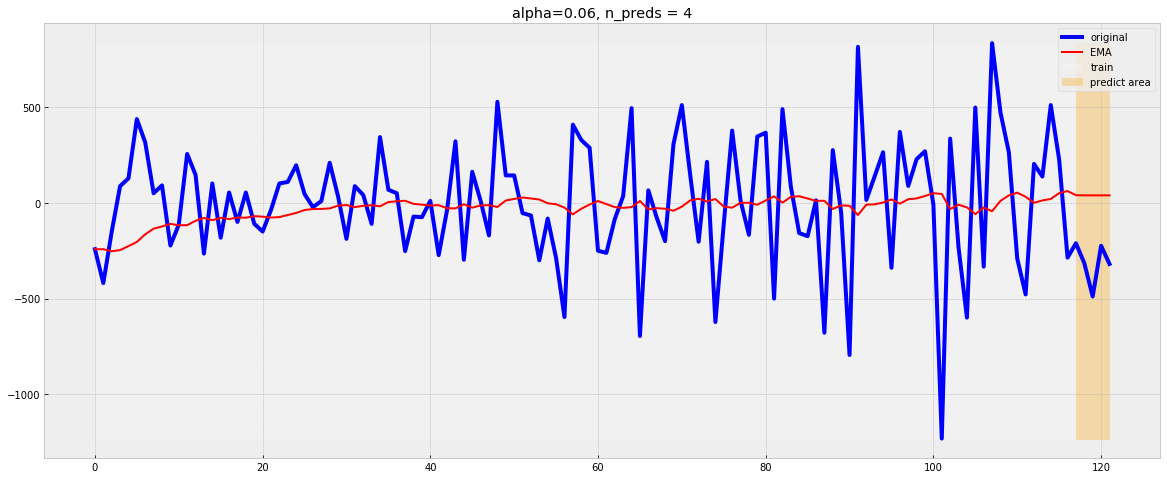

In [188]:
plot_ema(alpha_opt, series = train, series_to_plot = data_cons_clean)

Результат неважный. По факту предложенная модель оказалась практически аналогична модели среднего.